**FINAL PROJECT**

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import gc

In [5]:
from scipy import stats

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
from sklearn.model_selection import train_test_split

In [101]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [97]:
def evaluate_preds(true_values, pred_values, save=False):
    """Evaluation of model quality preds vs true"""
    
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mean_squared_error(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # line where true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

# Постановка Задачи

В качестве датасета для обработки взят SanFrancisco building permits c Kaggle.
Анализ планируется проводить по двум направлениям:
1. Построить модель и проерить возможность ее использования для предсказаний
2. Проверка гипотезы о величине Estimated Cost относительно Revised Cost
В качестве основной гипотезы (H0) принимается, что Revised Cost находится в диапазоне до 1,05 к изначальной оценочной стоимости проекта с учетом дополнительных факторов.  
Соответсвенно, гипотеза H1 предполагает, что среднее для Revised Cost будт вне этого диапазона.  

Целью работы является подтверждение или опровержение нулевой гипотезы.

# Решение

Загрузка и преобразование данных

In [8]:
init_data = pd.read_csv('Building_Permits.csv', dtype=str)

**Описание датасета**
Разрешение на строительство - это официальный разрешительный документ, выдаваемый государственным агентством, который позволяет вам или вашему подрядчику приступить к строительству или реконструкции своей собственности. В каждом городе или округе есть свой собственный офис, связанный со зданиями, который может выполнять несколько функций, таких как выдача разрешений, осмотр зданий для обеспечения соблюдения мер безопасности, изменение правил с учетом потребностей растущего населения и т. Д. Для города Сан-Франциско требуется выдача разрешений.  
Набор полей в датасете:
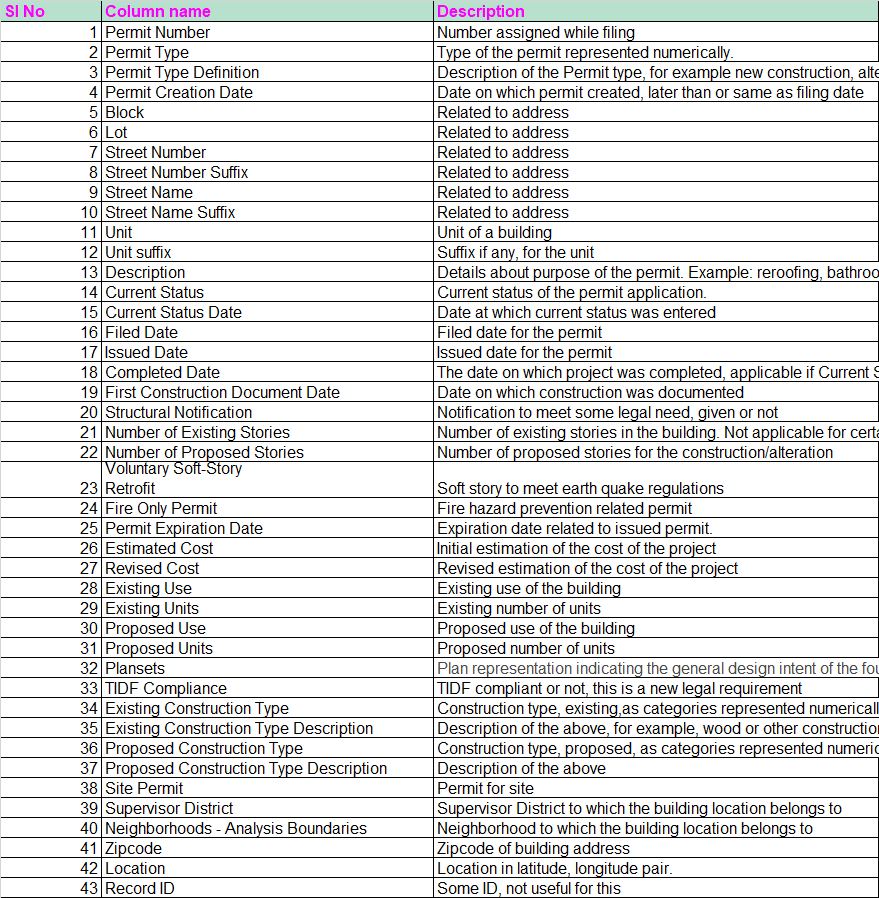

In [9]:
init_data.describe()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
count,198900,198900,198900,198900,198900,198900,198900,2216,198900,196132,...,155534,155534,155738,155738,5359,197183,197175,197184,197200,198900
unique,181495,8,8,1291,4896,1055,5099,18,1704,21,...,5,5,5,5,1,11,41,27,57604,198900
top,201602179765,8,otc alterations permit,09/15/2017,3708,001,1,A,Market,St,...,5,wood frame (5),5,wood frame (5),Y,3,Financial District/South Beach,94110,"(37.79226164705184, -122.4034859571375)",1436126274135
freq,101,178844,178844,413,1195,10114,2394,1501,5443,138358,...,113350,113350,114382,114382,5359,28649,21816,17837,554,1


In [10]:
init_data.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3,constr type 3,NaN,NaN,NaN,3,Tenderloin,94102,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3,constr type 3,NaN,NaN,NaN,3,Tenderloin,94102,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1,constr type 1,1,constr type 1,NaN,3,Russian Hill,94109,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5,wood frame (5),5,wood frame (5),NaN,3,Nob Hill,94109,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3,constr type 3,NaN,NaN,NaN,6,Tenderloin,94102,"(37.78315261897309, -122.40950883997789)",144548169992


In [11]:
init_data.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID'],
     

Для текущей задачи datetime величины нас не интересуют, поэтому все связанные колонны будут удалены из датасета наравне с другими величинами несущественными для статистического анализа для текущего проекта.  
К тому же анализ временных рядов выходит за рамки предполагаемого объема работы на данном этапе.

In [61]:
df = init_data.drop(['Permit Number', 
                            'Permit Type Definition', 
                            'Permit Creation Date', 
                            'Street Number Suffix', 
                            'Street Suffix', 
                            'Unit Suffix', 
                            'Current Status Date', 
                            'Issued Date', 
                            'Filed Date', 
                            'First Construction Document Date', 
                            'Structural Notification', 
                            'Number of Proposed Stories', 
                            'Voluntary Soft-Story Retrofit', 
                            'Permit Expiration Date', 
                             'TIDF Compliance', 
                            'Existing Construction Type Description', 
                            'Proposed Construction Type Description', 
                            'Neighborhoods - Analysis Boundaries',
                             'Location', 
                            'Record ID',
                            'Description', 
                            'Existing Use', 
                            'Existing Units', 
                            'Proposed Use', 
                            'Proposed Units',
                            'Plansets',
                            'Fire Only Permit',
                            'Lot',
                            'Unit', 
                            'Number of Existing Stories',
                            'Site Permit',
                            'Proposed Construction Type', 
                            'Street Name', 
                            'Existing Construction Type', 
                            'Current Status',
                            'Completed Date',
                            'Block'], axis=1)

In [62]:
df.head()

,Permit Type,Street Number,Estimated Cost,Revised Cost,Supervisor District,Zipcode
0,4,140,4000,4000,3,94102
1,4,440,1,500,3,94102
2,3,1647,20000,NaN,3,94109
3,8,1230,2000,2000,3,94109
4,6,950,100000,100000,6,94102


Проверка значений на Null

In [63]:
df.isnull().sum()

Permit Type                0
Street Number              0
Estimated Cost         38066
Revised Cost            6066
Supervisor District     1717
Zipcode                 1716
dtype: int64

Переименование колонок для удобства использования

In [64]:
df = df.rename(columns={'Permit Type':'PermitType', 
                          'Street Number':'StreetNumber', 
                          'Estimated Cost':'EstimatedCost', 
                          'Revised Cost':'RevisedCost', 
                          'Supervisor District':'SupervisorDistrict',
                          'Current Status':'CurrentStatus', 
                          'Completed Date':'CompletedDate'})

часть значений NaN  могут быть удалены ввиду тог, что их процент незначителен относительно оcнвной выборки.

In [65]:
df = df.dropna(subset=['SupervisorDistrict', 'Zipcode'])
df.isnull().sum()

PermitType                0
StreetNumber              0
EstimatedCost         37459
RevisedCost            6052
SupervisorDistrict        0
Zipcode                   0
dtype: int64

Добавим новую величину, являющуюся соотношением Revised Cost и EstimatedCost

Удалим из набора значения, где Estimated Cost и Revised Cost не присутствуют хотя бы в одной строке.

In [66]:
df = df[(~df['EstimatedCost'].isnull()) & (~df['RevisedCost'].isnull())]

In [67]:
df.isnull().sum()

PermitType            0
StreetNumber          0
EstimatedCost         0
RevisedCost           0
SupervisorDistrict    0
Zipcode               0
dtype: int64

Перед тем как привести датасет к виду, допускающему обработку статистическими функциями необходимо определить форму данных и определить выбросы.

In [68]:
df.describe()

,PermitType,StreetNumber,EstimatedCost,RevisedCost,SupervisorDistrict,Zipcode
count,154268,154268,154268,154268,154268,154268
unique,8,4972,11094,12527,11,27
top,8,1,1,1,3,94110
freq,139767,2140,16660,14963,22842,13333


In [69]:
df['PermitType'] = df['PermitType'].astype('int32')

In [70]:
df['EstimatedCost'] = df['EstimatedCost'].astype('float')
df['RevisedCost'] = df['RevisedCost'].astype('float')
df['SupervisorDistrict'] = df['SupervisorDistrict'].astype('int32')
df['Zipcode'] = df['Zipcode'].astype('int32')

Добавим новую величину, являющуюся соотношением величин 'Revised Cost' и 'Estimated Cost'

In [71]:
df['Ratio'] = df['RevisedCost']/df['EstimatedCost']

In [72]:
df.head()

,PermitType,StreetNumber,EstimatedCost,RevisedCost,SupervisorDistrict,Zipcode,Ratio
0,4,140,4000.0,4000.0,3,94102,1.0
1,4,440,1.0,500.0,3,94102,500.0
3,8,1230,2000.0,2000.0,3,94109,1.0
4,6,950,100000.0,100000.0,6,94102,1.0
5,8,800,4000.0,4000.0,10,94107,1.0


**Анализ величин и работа с выбросами**

Создаем боксплот для наших целевых величин из датасета.

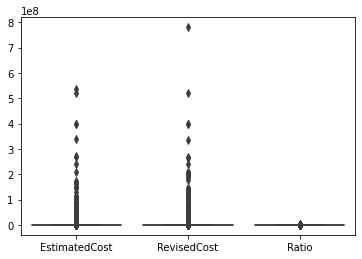

In [73]:
ax = sns.boxplot(data = df[['EstimatedCost', 'RevisedCost', 'Ratio']]                )
plt.show()


Для приведения статистики к более удобному виду для последующей обработки отбросим 5% выбросов с наибольшей величиной для обеих целевх переменных.

In [74]:
df = df[(df['EstimatedCost'] <= 250000) & (df['EstimatedCost'] >0)]

Повторим аналогичную операцию с RevisedCost c учетом уже удаленных записей для EstimatedCost

In [75]:
df = df[(df['RevisedCost'] <= 250000) & (df['RevisedCost'] > 0)]

In [76]:
df = df[(df['Ratio'] > 0.1) & (df['Ratio'] < 100)]

In [77]:
df['Ratio'].describe()

count    138988.000000
mean          1.341788
std           1.938317
min           0.101124
25%           1.000000
50%           1.000000
75%           1.000000
max          85.000000
Name: Ratio, dtype: float64

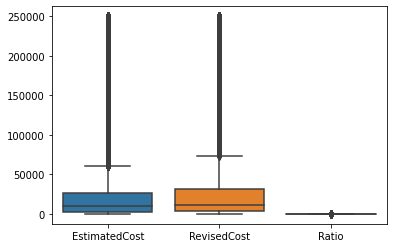

In [78]:
ax = sns.boxplot(data = df[['EstimatedCost', 'RevisedCost', 'Ratio']]                )
plt.show()


Выбросы сохранились, но боксплот уже виден, что позволяет попробовать продолжить обработку. 

In [79]:
df.describe()

,PermitType,EstimatedCost,RevisedCost,SupervisorDistrict,Zipcode,Ratio
count,138988.000000,138988.000000,138988.000000,138988.000000,138988.000000,138988.000000
mean,7.664662,23822.257658,28396.169487,5.606923,94115.644869,1.341788
std,1.211574,37152.792603,43050.468783,2.884915,9.296544,1.938317
min,1.000000,1.000000,1.000000,1.000000,94102.000000,0.101124
25%,8.000000,3000.000000,3500.000000,3.000000,94109.000000,1.000000
50%,8.000000,10000.000000,11000.000000,6.000000,94114.000000,1.000000
75%,8.000000,26000.000000,31600.000000,8.000000,94122.000000,1.000000
max,8.000000,250000.000000,250000.000000,11.000000,94158.000000,85.000000


Можно увидеть, что существует относительно большое количество выбросов для обеих целевых величин.
Для статистических исследований в текущей ситуации имеет смысл ограничить набор величин в пределах шести сигм.

Обработанные величины, так же как и остальные, могут быть теперь представлены в виде гистограмм

array([[<AxesSubplot:title={'center':'PermitType'}>,
        <AxesSubplot:title={'center':'EstimatedCost'}>],
       [<AxesSubplot:title={'center':'RevisedCost'}>,
        <AxesSubplot:title={'center':'SupervisorDistrict'}>],
       [<AxesSubplot:title={'center':'Zipcode'}>,
        <AxesSubplot:title={'center':'Ratio'}>]], dtype=object)

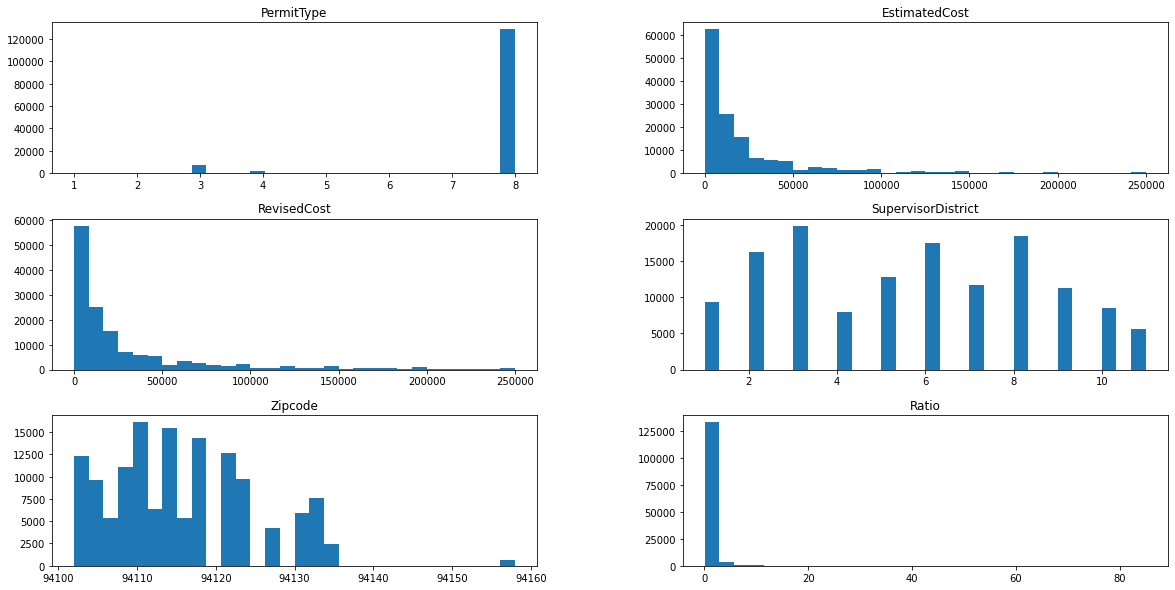

In [80]:
df.hist(figsize=(20,10), bins = 30, grid=False)

Распределение целевых величин несимметричное и явно не является нормальным, поэтому необходимо использовать статистики для несимметричных распределений.

c:\users\пк\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


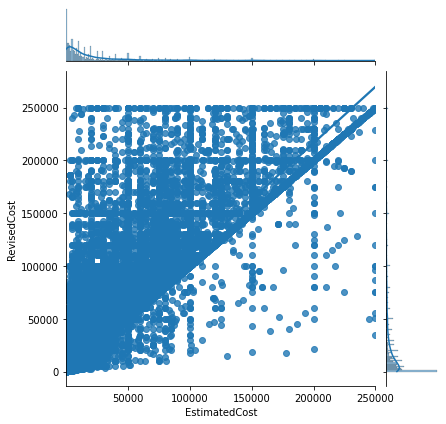

In [86]:
grid = sns.jointplot(df['EstimatedCost'], df['RevisedCost'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

Для подтверждения ненормальности распределения воспользуемся соответствующими стандартными функциями из модуля scipy

In [81]:
stat, p = stats.normaltest(df['EstimatedCost'])
stat, p

(87296.00195368417, 0.0)

In [82]:
stat, p = stats.normaltest(df['RevisedCost'])
stat, p

(75421.20403506792, 0.0)

Т.к. распределение не является нормальным, будем использовать коэффициент корреляции Спирмена для определения связи между EsyimatedCost и RevisedCost

In [83]:
pd.DataFrame({'x': df['EstimatedCost'], 'y': df['RevisedCost']}).corr(method='kendall')

,x,y
x,1.000000,0.908928
y,0.908928,1.000000


несмотря на то, что распределение ненормальное, присутствует сильная корреляция между EstimatedCost и RevisedCost

In [84]:
keys = ['EstimatedCost', 'RevisedCost', 'Ratio']

Дополнительное проверка при помощи правил разюроса для нормального распределения

In [85]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

EstimatedCost
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8975451118082136
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9456140098425764
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9714147983998619

RevisedCost
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8831337957233718
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9423547356606325
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9710478602469278

Ratio
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9677238322732897
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9855599044521829
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9906322848015656



Как и ожидалось, ни одно из распределений не является нормальным.

Предположительно, Estimaetd Cost и Revised Cost связаны между собой линейно.
Проверим это при помощи построения уравнения линейной регрессии.

**Уравнение Линейной Регресии**

Составим уравнение линейной регресии для зависимости Revised Cost от Estimated Cost

In [88]:
X = df['EstimatedCost']
y = df['RevisedCost']

In [89]:
b1 = (np.mean(X * y) - np.mean(X) * np.mean(y)) / (np.mean(X ** 2) - np.mean(X) ** 2)
b0 = np.mean(y) - b1 * np.mean(X)

b0, b1

(2983.9652525283054, 1.0667420611480152)

Следовательно, уравнение линейной ререссии имеет вид:  
$$y = 2983.9652 + 1.0667 * x$$

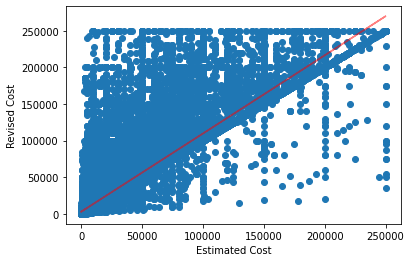

In [90]:
ox = X
oy = b0 + b1 * ox

plt.scatter(X, y)
plt.plot(ox, oy, color='red', alpha=0.5)

plt.xlabel('Estimated Cost')
plt.ylabel('Revised Cost');

Проверка линейной модели при помощи sklearn и предсказания.

In [93]:
X = df[['EstimatedCost']]
y = df['RevisedCost']

In [92]:
lr_model = LinearRegression()

In [94]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state = 42)

In [95]:
lr_model.fit(X_train_lr, y_train_lr)

LinearRegression()

Проверка коэффициентов выбранных моделью.

In [103]:
lr_model.intercept_, lr_model.coef_

(2961.030938277323, array([1.06709408]))

**Различие в коэффициентах менее 1%**

In [96]:
y_pred_lr = lr_model.predict(X_test_lr)

R2:	0.843
RMSE:	16999.228
MSE:	288973764.061


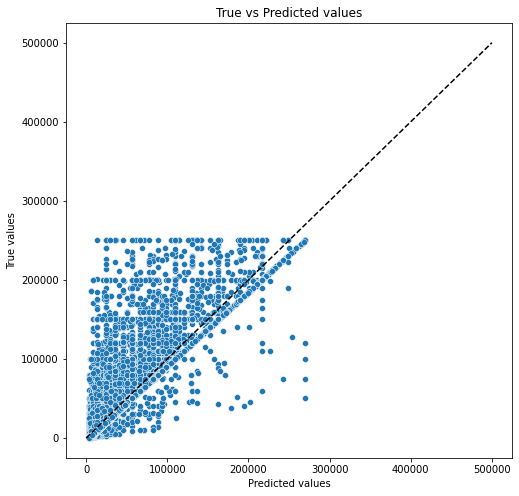

In [102]:
evaluate_preds(y_test_lr, y_pred_lr)

Достаточно высокое значение коэффициента детерминации (R2_score) показывает,что модель удовлетворительно описывает взаимосвязь между переменными.

Проверим значимость линейной модели проверкой при помощи F-теста:

In [130]:
R2 = 0.843

In [127]:
n = X.shape[0]
m = 1

k1 = m
k2 = n - m - 1

k1, k2

(1, 138986)

Примем стандартный уровень значимости 0,05

In [128]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

3.8415257285456135

In [131]:
F = (R2 / k1) / ((1 - R2) / k2)
F

746275.1464968151

анализ тех же данных при помощи пакета OLS

In [133]:
import statsmodels.api as sm
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            RevisedCost   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                          1.140e+06
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                        0.00
Time:                        15:21:01   Log-Likelihood:                     -1.5511e+06
No. Observations:              138988   AIC:                                  3.102e+06
Df Residuals:                  138987   BIC:                                  3.102e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Статистика попала в критическую область. С этой точки зрения уравнение следует признать значимым.

**Приступим ко второй части задания**

Проводим анализ величины Ratio

<AxesSubplot:>

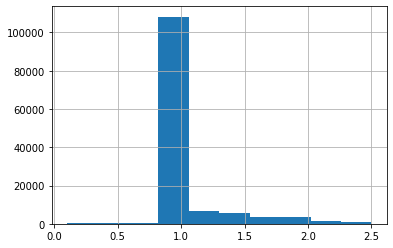

In [164]:
df['Ratio'][df['Ratio'] < 2.5].hist()


<AxesSubplot:>

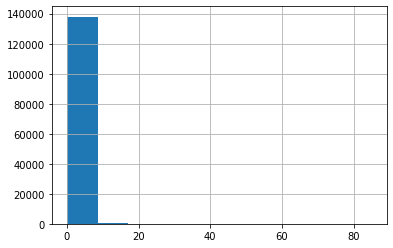

In [165]:
df['Ratio'].hist()

Распределение не изменилось даже после применения преобразования кубического корня, поэтому, оставим как есть.

In [162]:
df['Ratio'][(df['Ratio'] < 2.5) & (df['Ratio'] > 0.75)].count()/df['Ratio'].count()

0.9388076668489366

Считаем стандартные статистические величины для величины Ratio

In [154]:
rat_mode = df['Ratio'].mode()
rat_mode

0    1.0
dtype: float64

In [155]:
rat_median = df['Ratio'].median()
rat_median

1.0

In [156]:
rat_mean = df['Ratio'].mean()
rat_mean

1.341787896795134

Для гипотезы H0 mu <=1.05

Т.к. фактическое значение среднего больше изначально заданного, то можно сделать вывод, что нулевую гипотезу следует отвергнуть.

Проверим выод при помощи статистических функций.  
За основу возьмем распределение Фишера, как одностороннее.

In [167]:
n = df['Ratio'].shape[0]
m = 1

k1 = m
k2 = n - m - 1

k1, k2

(1, 138986)

In [ ]:
Расссчитываем величину p и сравниваем 

In [184]:
p_r = stats.f.cdf(1 - alpha, k1, k2)
p_value = 1 -p_r
p_value

0.32972099365724583

P значение выше принятого уровня значимости, т.е. нулевую гипотезу можно отвергнуть.

# Выводы

Распределение переменный является односторонним, смещенным влево, поэтому методы статистического анализа для нормальных распределений неприменимы к данному случаю.  
Взаимосвязь переменных, выбранных для анализа достоточно хорошо укладывается в уравнение линейной регресии.  
Величина соотношения указанная в условиях достаточно хорошо ложится в полученный резудьтат, т.е. нулевую гипотезу можно отвергнуть. И, следовательно, фактический уровень затрат всегда превыгает изначально проектируемый в среднем на величину порядка 34%.
